# How do package dependency network grow over time?

In this notebook we plan to investigate the dependencies in the Pypi dataset and try to look at
how they change over time.

## Loading data and importing libraries

In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

## Defining helper functions and defaults

In [2]:
# Helper Functions
def add_three_months(t):
    for i in range(1):
        t = add_a_month(t)
    return t
def add_a_month(t):
    return (t.replace(day=1) + datetime.timedelta(days=31)).replace(day=1)
def print_time(t):
    return t.strftime("%Y-%m-%dT%H:%M:%S")

!mkdir figs
figs_dir = 'figs/'

mkdir: cannot create directory ‘figs’: File exists


In [3]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    
set_plt_rc()

# Transitive Dependencies

In [4]:

data_folder = '../data/'

requirements = pd.read_csv(data_folder + 'data_all.csv')
requirements.loc[:,'package_name'] = requirements.loc[:,'name']
requirements.loc[:,'requirement'] = requirements.loc[:,'deps']

requirements.loc[:,'package_name'] = requirements.loc[:,'package_name'].apply(lambda x: x.lower() if type(x)==str else x)
requirements.loc[:,'requirement'] = requirements.loc[:,'requirement'].apply(lambda x: x.lower() if type(x)==str else x)

requirements.loc[:,'date'] = requirements.loc[:,'date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))



sub = requirements

data_folder = '../data/'
requirements = pd.read_csv(data_folder + 'reqs.csv')
requirements.loc[:,'package_name'] = requirements.loc[:,'package_name'].apply(lambda x: x.lower() if type(x)==str else x)
requirements.loc[:,'requirement'] = requirements.loc[:,'requirement'].apply(lambda x: x.lower() if type(x)==str else x)

requirements.head()

,package_name,requirement
0,0.0.1,tensorflow
1,0.0.1,pandas
2,115wangpan,pycurl
3,115wangpan,six
4,115wangpan,humanize


In [5]:
sub.head()

,name,version,date,deps,package_name,requirement
0,0.0.1,0.0.1,2017-12-20,tensorflow,0.0.1,tensorflow
1,0.0.1,0.0.1,2017-12-20,pandas,0.0.1,pandas
2,115wangpan,0.1.0,2014-09-11,six,115wangpan,six
3,115wangpan,0.1.0,2014-09-11,beautifulsoup4,115wangpan,beautifulsoup4
4,115wangpan,0.1.0,2014-09-11,humanize,115wangpan,humanize


In [6]:
from tqdm.autonotebook import tqdm

tqdm.pandas()

/home/ubuntu/anaconda3/envs/mlse/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
dep_cache = {}
MAX_LEVEL = 10

def get_direct_deps(p):
    if p in dep_cache:
        return dep_cache[p][1]
    
    direct_deps = list(requirements.loc[requirements.loc[:, 'package_name'] == p, 'requirement'])
#     print('direct_deps', p, direct_deps)
    return direct_deps

def get_all_deps(p, level=1, old_deps=None):
    if old_deps is None:
        old_deps = []
    if level > MAX_LEVEL:
        return -1, -1
    if p in dep_cache:
        return dep_cache[p]
    
#     print(p)
    
    direct_deps = get_direct_deps(p)
    all_deps = []
    for req in direct_deps:
        if req in old_deps:
            continue
        d, _ = get_all_deps(req, level+1, all_deps + old_deps)
        if d == -1:
            return list(set(all_deps)), list(set(direct_deps))
#             return -1, -1
        all_deps += d
    
    all_deps += direct_deps
    
    dep_cache[p] = (list(set(all_deps)), list(set(direct_deps)))
    return list(set(all_deps)), list(set(direct_deps))

def get_transitive_deps(p):
    a,d = get_all_deps(p)
    if a == -1:
        return -1
    return set(a) - set(d)
    
# get_all_deps('matplotlib')
# get_all_deps('actionbar.babble')

# get_transitive_deps('zope')
# get_transitive_deps('actionbar.babble')

# Automated Process

In [9]:
first_time = sub['date'].min()
last_time = sub['date'].max()
print('soonest start time:', first_time)
print('latest start time:', last_time)

soonest start time: 2005-08-27 00:00:00
latest start time: 2018-01-20 00:00:00


In [12]:
sub.loc[:,'tran_deps'] = sub.loc[:,'package_name'].progress_apply(get_transitive_deps)
sub.loc[:,'tran_deps_lens'] = sub.loc[:,'tran_deps'].apply(lambda x: len(x))
sub.loc[:,'dir_deps_lens'] = sub.loc[:,'package_name'].apply(lambda x: len(get_direct_deps(x)))
sub.loc[:,'ratios'] = sub.apply(lambda x: x['tran_deps_lens'] / x['dir_deps_lens'], axis=1)

ratio = sub.loc[:,'ratios'].mean()

print('Overal Ratio:', ratio)

Overal Ratio: 2.6282278550768043


In [16]:
project_counts = {}
project_counts['StartDate'] = []
project_counts['EndDate'] = []
project_counts['ratios'] = []

start_time = add_a_month(first_time)
end_time = add_three_months(start_time)
while end_time < last_time.replace(day=1):
    project_counts['StartDate'].append(start_time)
    project_counts['EndDate'].append(end_time)

    idxs = (sub['date'] > start_time) & (sub['date'] < end_time)
    subset = sub.loc[idxs, :]

    ratio = subset.loc[:,'ratios'].mean()
    print('Time:', start_time, '-', ratio)

    project_counts['ratios'].append(ratio)


    start_time = end_time
    end_time = add_three_months(start_time)

Time: 2005-09-01 00:00:00 - 2.0
Time: 2005-10-01 00:00:00 - 0.14285714285714285
Time: 2005-11-01 00:00:00 - 4.75
Time: 2005-12-01 00:00:00 - 0.26666666666666666
Time: 2006-01-01 00:00:00 - 0.21739130434782608
Time: 2006-02-01 00:00:00 - 0.4444444444444444
Time: 2006-03-01 00:00:00 - 0.6801075268817205
Time: 2006-04-01 00:00:00 - 1.097142857142857
Time: 2006-05-01 00:00:00 - 0.8913043478260869
Time: 2006-06-01 00:00:00 - 1.5555555555555556
Time: 2006-07-01 00:00:00 - 0.6650943396226416
Time: 2006-08-01 00:00:00 - 0.7910447761194029
Time: 2006-09-01 00:00:00 - 1.37442451728166
Time: 2006-10-01 00:00:00 - 2.3314935064935067
Time: 2006-11-01 00:00:00 - 1.0441176470588236
Time: 2006-12-01 00:00:00 - 2.1815980629539955
Time: 2007-01-01 00:00:00 - 2.6587301587301586
Time: 2007-02-01 00:00:00 - 1.3728186084758143
Time: 2007-03-01 00:00:00 - 2.4422486357457
Time: 2007-04-01 00:00:00 - 2.367869916858387
Time: 2007-05-01 00:00:00 - 1.5544715347713376
Time: 2007-06-01 00:00:00 - 2.0665674760920427

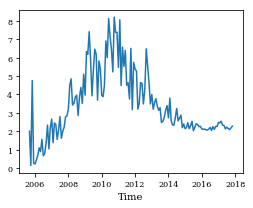

In [18]:
plt.figure(figsize=(4,3))

plt.plot(project_counts['StartDate'], project_counts['ratios'])
plt.xlabel('Time')
# plt.ylabel('Transitive Dependencies / Direct Dependencies')

plt.savefig(figs_dir+'trans-deps-over-time.pdf')
plt.savefig(figs_dir+'trans-deps-over-time.png', dpi=300)